Centralized MSE (Baseline): 0.5506


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/usr/loca

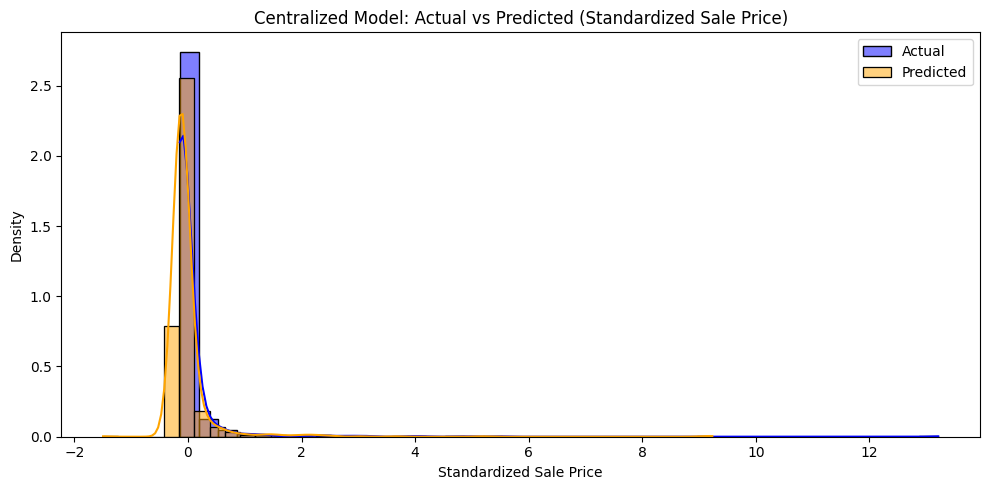

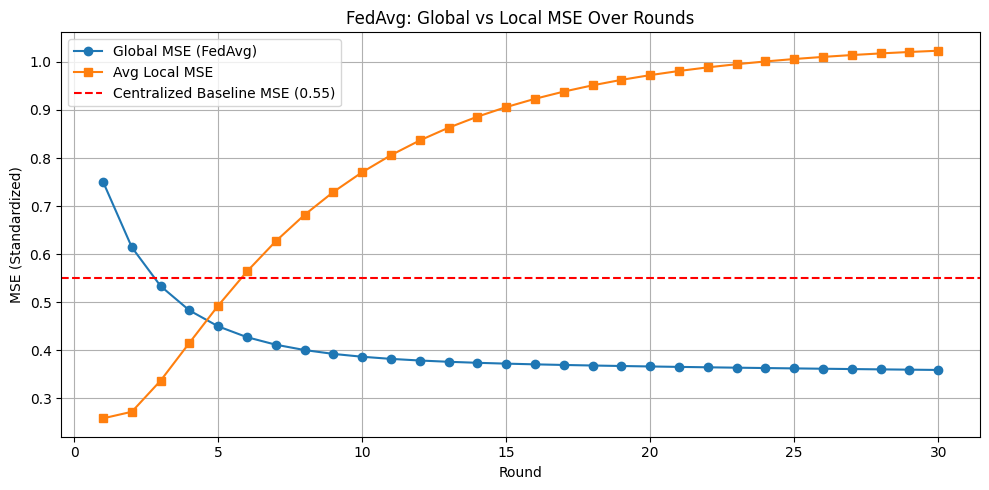

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/cleaned_federated_dataset.csv")

# Clean and prepare numeric columns
for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
    df[col] = pd.to_numeric(df[col].replace(' ', np.nan), errors='coerce')

df = df[(df['SALE PRICE'] > 0) & (df['CLIENT_ID'].notnull())]
features = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TOTAL UNITS']
df_clean = df[features + ['SALE PRICE', 'CLIENT_ID']].dropna()

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(df_clean[features])
y_scaled = scaler_y.fit_transform(df_clean[['SALE PRICE']])

df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['SALE PRICE'] = y_scaled
df_scaled['CLIENT_ID'] = df_clean['CLIENT_ID'].values

# Centralized Model
# Centralized Model (Full Data Baseline)
X_baseline = df_scaled[features]
y_baseline = df_scaled['SALE PRICE']

central_model = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=0.001, random_state=42)
central_model.fit(X_baseline, y_baseline)
y_pred_baseline = central_model.predict(X_baseline)

baseline_mse = mean_squared_error(y_baseline, y_pred_baseline)
print(f"Centralized MSE (Baseline): {baseline_mse:.4f}")


# FedAvg Setup
clients = dict(tuple(df_scaled.groupby("CLIENT_ID")))
n_rounds = 30
learning_rate = 0.001
base_model = SGDRegressor(max_iter=1, learning_rate='constant', eta0=learning_rate, warm_start=True, random_state=42)
sample_X = df_scaled[features]
sample_y = df_scaled['SALE PRICE']
base_model.fit(sample_X.head(5), sample_y.head(5))  # initialize

global_coef = base_model.coef_.copy()
global_intercept = np.array([base_model.intercept_ if isinstance(base_model.intercept_, float) else base_model.intercept_[0]])

global_mse_over_rounds = []
avg_local_mse_over_rounds = []

for rnd in range(n_rounds):
    total_samples = 0
    coef_sum = np.zeros_like(global_coef)
    intercept_sum = 0.0
    local_mse_list = []

    for client_id, data in clients.items():
        X_local = data[features]
        y_local = data['SALE PRICE']
        local_model = clone(base_model)
        local_model.coef_ = global_coef.copy()
        local_model.intercept_ = global_intercept.copy()
        local_model.fit(X_local, y_local)

        y_local_pred = local_model.predict(X_local)
        local_mse = mean_squared_error(y_local, y_local_pred)
        local_mse_list.append(local_mse)

        n = len(X_local)
        coef_sum += local_model.coef_ * n
        intercept_sum += float(local_model.intercept_[0]) * n
        total_samples += n

    global_coef = coef_sum / total_samples
    global_intercept = np.array([intercept_sum / total_samples])
    global_model = clone(base_model)
    global_model.coef_ = global_coef
    global_model.intercept_ = global_intercept
    y_global_pred = global_model.predict(sample_X)
    global_mse = mean_squared_error(sample_y, y_global_pred)

    global_mse_over_rounds.append(global_mse)
    avg_local_mse_over_rounds.append(np.mean(local_mse_list))


# ------------------- PLOT 8: Actual vs Predicted Sale Price -------------------
plt.figure(figsize=(10, 5))
sns.histplot(y_test, label='Actual', color='blue', kde=True, stat='density', bins=40)
sns.histplot(y_test_pred, label='Predicted', color='orange', kde=True, stat='density', bins=40)
plt.legend()
plt.title("Centralized Model: Actual vs Predicted (Standardized Sale Price)")
plt.xlabel("Standardized Sale Price")
plt.tight_layout()
plt.show()

# ------------------- MSE Over Rounds Plot with Centralized Baseline -------------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_rounds + 1), global_mse_over_rounds, label='Global MSE (FedAvg)', marker='o')
plt.plot(range(1, n_rounds + 1), avg_local_mse_over_rounds, label='Avg Local MSE', marker='s')
plt.axhline(y=baseline_mse, color='red', linestyle='--', label=f'Centralized Baseline MSE ({baseline_mse:.2f})')
plt.title("FedAvg: Global vs Local MSE Over Rounds")
plt.xlabel("Round")
plt.ylabel("MSE (Standardized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# New Section